In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score
from imblearn.over_sampling import SMOTE, ADASYN

# ----- 常量 -----
R, L, theta, alpha = 0.04, 0.125, np.deg2rad(30), 0


In [2]:
df = pd.read_excel('Data_Set_(A+B).xlsx')
y = (df['Type'] == 4).astype(int)

# V1real–V3real 直接视为 rad/s；如是 RPM 请乘 2π/60
ω = df[['V1real','V2real','V3real']].values.T      # w1,w2,w3
I = df[['I1','I2','I3']].values.T                  # I1,I2,I3

Vx =  R * (-2/3*np.cos(theta)*ω[0] + 2/3*np.sin(theta)*ω[1] + 2/3*np.cos(theta)*ω[2])
Vy =  R * (-2/3*np.sin(theta)*ω[0] - 2/3*ω[1]      + 2/3*np.sin(theta)*ω[2])
Omega = (ω[0]+ω[1]+ω[2]) / (3*L)

Ix = -2/3*np.cos(theta)*I[0] + 2/3*np.sin(theta)*I[1] + 2/3*np.cos(theta)*I[2]
Iy = -2/3*np.sin(theta)*I[0] - 2/3*I[1]             + 2/3*np.sin(theta)*I[2]
Iphi = (I[0]+I[1]+I[2]) / 3

X_base = pd.DataFrame({'Vx':Vx,'Vy':Vy,'Omega':Omega,
                       'Ix':Ix,'Iy':Iy,'Iphi':Iphi})
X_base.head()


,Vx,Vy,Omega,Ix,Iy,Iphi
0,11.947436,6.734118,55.058824,-0.107909,-0.080443,0.691805
1,12.103979,6.988235,8.470588,-0.044608,-0.038713,0.669180
2,12.397408,7.157647,0.000000,0.022408,0.009050,0.620915
3,-3.610235,8.449412,-8.470588,0.303764,-0.818501,0.799899
4,-3.862833,8.576471,29.647059,0.297837,-0.707894,0.669181


In [5]:
import os, pathlib; os.environ['JOBLIB_TEMP_FOLDER']=r'E:\joblib_tmp'
pathlib.Path(r'E:\joblib_tmp').mkdir(exist_ok=True)


from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.neural_network import MLPClassifier

param_grid = {
    'hidden_layer_sizes': [(5,), (10,), (15,),
                           (20,), (20,10), (30,15)],
    'activation': ['tanh', 'relu', 'logistic'],
    'solver': ['lbfgs', 'adam'],
    'max_iter': [500, 1000, 1000],
    'random_state': [0, 21, 42],
}

cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

gs = GridSearchCV(
        estimator = MLPClassifier(),
        param_grid = param_grid,
        cv = cv,
        scoring = 'f1',
        n_jobs = 1,        # <- 为避免 UnicodeEncodeError
        verbose = 2        # 看进度
)
gs.fit(X_base, y)

print('Лучшие параметры:', gs.best_params_)
print('Лучший F1 (CV):',  round(gs.best_score_, 3))
best_model = gs.best_estimator_


## 3. Обучение сети на сортированных данных


In [8]:
from sklearn.model_selection import StratifiedKFold

# 定义参数网格
param_grid = {
    'hidden_layer_sizes': [(50,), (100,)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'learning_rate_init': [0.001, 0.01]
}

# 定义交叉验证策略
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# ── 3.1  Отсортируем обучающую выборку ──────────────────────────
df_sorted = df.sort_values(['Type','I1']).reset_index(drop=True)
X_sorted  = X_base.loc[df_sorted.index]

# 修改这里，y_sorted转换为二分类标签，Type==5为1，其它为0
y_sorted  = (y.loc[df_sorted.index] == 5).astype(int)

# ── 3.2  Повторим GridSearch на отсортированных данных ─────────
gs_sort = GridSearchCV(
    MLPClassifier(max_iter=500),  # 建议加max_iter防止训练不收敛
    param_grid,
    cv=cv,
    scoring='f1',
    n_jobs=1,
    verbose=2
)
gs_sort.fit(X_sorted, y_sorted)

print('Sorted best F1:', gs_sort.best_score_.round(3))
print(gs_sort.best_params_)
best_sort = gs_sort.best_estimator_


Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END activation=relu, hidden_layer_sizes=(50,), learning_rate_init=0.001, solver=adam; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(50,), learning_rate_init=0.001, solver=adam; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(50,), learning_rate_init=0.001, solver=adam; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(50,), learning_rate_init=0.01, solver=adam; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(50,), learning_rate_init=0.01, solver=adam; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(50,), learning_rate_init=0.01, solver=adam; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(100,), learning_rate_init=0.001, solver=adam; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(100,), learning_rate_init=0.001, solver=adam; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(100,), learning

c:\Users\HUAWEI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\HUAWEI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "c:\Users\HUAWEI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "c:\Users\HUAWEI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 380, in _score
    y_pred = method_caller(
  File "c:\Users\HUAWEI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 90, in _cached_call
    resul

[CV] END activation=relu, hidden_layer_sizes=(100,), learning_rate_init=0.01, solver=adam; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(100,), learning_rate_init=0.01, solver=adam; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(50,), learning_rate_init=0.001, solver=adam; total time=   0.1s


c:\Users\HUAWEI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\HUAWEI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "c:\Users\HUAWEI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "c:\Users\HUAWEI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 380, in _score
    y_pred = method_caller(
  File "c:\Users\HUAWEI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 90, in _cached_call
    resul

[CV] END activation=tanh, hidden_layer_sizes=(50,), learning_rate_init=0.001, solver=adam; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(50,), learning_rate_init=0.001, solver=adam; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(50,), learning_rate_init=0.01, solver=adam; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(50,), learning_rate_init=0.01, solver=adam; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(50,), learning_rate_init=0.01, solver=adam; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(100,), learning_rate_init=0.001, solver=adam; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(100,), learning_rate_init=0.001, solver=adam; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(100,), learning_rate_init=0.001, solver=adam; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(100,), learning_rate_init=0.01, solver=adam; total time=   0.0s
[CV] END a

c:\Users\HUAWEI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\HUAWEI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "c:\Users\HUAWEI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "c:\Users\HUAWEI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 380, in _score
    y_pred = method_caller(
  File "c:\Users\HUAWEI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 90, in _cached_call
    resul

Sorted best F1: 0.891
{'activation': 'logistic', 'hidden_layer_sizes': (20,), 'max_iter': 1000, 'random_state': 42, 'solver': 'lbfgs'}

## 4. Обучение сети на нормализованных данных


In [14]:
# ── 4.1  Масштабирование ───────────────────────────────────────
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X_sorted)

# ── 4.2  GridSearch ────────────────────────────────────────────
gs_norm = GridSearchCV(
    MLPClassifier(), param_grid, cv=cv, scoring='f1', n_jobs=1, verbose=2
)
gs_norm.fit(X_norm, y_sorted)

print('Norm best F1:', gs_norm.best_score_.round(3))
print(gs_norm.best_params_)
best_norm = gs_norm.best_estimator_


Fitting 4 folds for each of 324 candidates, totalling 1296 fits
[CV] END activation=tanh, hidden_layer_sizes=(5,), max_iter=500, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(5,), max_iter=500, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(5,), max_iter=500, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(5,), max_iter=500, random_state=0, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(5,), max_iter=500, random_state=0, solver=adam; total time=   0.1s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(5,), max_iter=500, random_state=0, solver=adam; total time=   0.2s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(5,), max_iter=500, random_state=0, solver=adam; total time=   0.1s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(5,), max_iter=500, random_state=0, solver=adam; total time=   0.1s
[CV] END activation=tanh, hidden_layer_sizes=(5,), max_iter=500, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(5,), max_iter=500, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(5,), max_iter=500, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(5,), max_iter=500, random_state=21, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(5,), max_iter=500, random_state=21, solver=adam; total time=   0.1s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(5,), max_iter=500, random_state=21, solver=adam; total time=   0.2s
[CV] END activation=tanh, hidden_layer_sizes=(5,), max_iter=500, random_state=21, solver=adam; total time=   0.1s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(5,), max_iter=500, random_state=21, solver=adam; total time=   0.1s
[CV] END activation=tanh, hidden_layer_sizes=(5,), max_iter=500, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(5,), max_iter=500, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(5,), max_iter=500, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(5,), max_iter=500, random_state=42, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(5,), max_iter=500, random_state=42, solver=adam; total time=   0.1s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(5,), max_iter=500, random_state=42, solver=adam; total time=   0.2s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(5,), max_iter=500, random_state=42, solver=adam; total time=   0.1s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(5,), max_iter=500, random_state=42, solver=adam; total time=   0.1s
[CV] END activation=tanh, hidden_layer_sizes=(5,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(5,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(5,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(5,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(5,), max_iter=1000, random_state=0, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(5,), max_iter=1000, random_state=0, solver=adam; total time=   0.4s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(5,), max_iter=1000, random_state=0, solver=adam; total time=   0.4s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(5,), max_iter=1000, random_state=0, solver=adam; total time=   0.4s
[CV] END activation=tanh, hidden_layer_sizes=(5,), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(5,), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(5,), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(5,), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(5,), max_iter=1000, random_state=21, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(5,), max_iter=1000, random_state=21, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(5,), max_iter=1000, random_state=21, solver=adam; total time=   0.4s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(5,), max_iter=1000, random_state=21, solver=adam; total time=   0.3s
[CV] END activation=tanh, hidden_layer_sizes=(5,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(5,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(5,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(5,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(5,), max_iter=1000, random_state=42, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(5,), max_iter=1000, random_state=42, solver=adam; total time=   0.3s
[CV] END activation=tanh, hidden_layer_sizes=(5,), max_iter=1000, random_state=42, solver=adam; total time=   0.4s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(5,), max_iter=1000, random_state=42, solver=adam; total time=   0.4s
[CV] END activation=tanh, hidden_layer_sizes=(5,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(5,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(5,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(5,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(5,), max_iter=1000, random_state=0, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(5,), max_iter=1000, random_state=0, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(5,), max_iter=1000, random_state=0, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(5,), max_iter=1000, random_state=0, solver=adam; total time=   0.2s
[CV] END activation=tanh, hidden_layer_sizes=(5,), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(5,), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(5,), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(5,), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(5,), max_iter=1000, random_state=21, solver=adam; total time=   0.2s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(5,), max_iter=1000, random_state=21, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(5,), max_iter=1000, random_state=21, solver=adam; total time=   0.4s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(5,), max_iter=1000, random_state=21, solver=adam; total time=   0.3s
[CV] END activation=tanh, hidden_layer_sizes=(5,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(5,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(5,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(5,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(5,), max_iter=1000, random_state=42, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(5,), max_iter=1000, random_state=42, solver=adam; total time=   0.4s
[CV] END activation=tanh, hidden_layer_sizes=(5,), max_iter=1000, random_state=42, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(5,), max_iter=1000, random_state=42, solver=adam; total time=   0.3s
[CV] END activation=tanh, hidden_layer_sizes=(10,), max_iter=500, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(10,), max_iter=500, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(10,), max_iter=500, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(10,), max_iter=500, random_state=0, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(10,), max_iter=500, random_state=0, solver=adam; total time=   0.2s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(10,), max_iter=500, random_state=0, solver=adam; total time=   0.1s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(10,), max_iter=500, random_state=0, solver=adam; total time=   0.1s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(10,), max_iter=500, random_state=0, solver=adam; total time=   0.2s
[CV] END activation=tanh, hidden_layer_sizes=(10,), max_iter=500, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(10,), max_iter=500, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(10,), max_iter=500, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(10,), max_iter=500, random_state=21, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(10,), max_iter=500, random_state=21, solver=adam; total time=   0.1s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(10,), max_iter=500, random_state=21, solver=adam; total time=   0.2s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(10,), max_iter=500, random_state=21, solver=adam; total time=   0.2s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(10,), max_iter=500, random_state=21, solver=adam; total time=   0.1s
[CV] END activation=tanh, hidden_layer_sizes=(10,), max_iter=500, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(10,), max_iter=500, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(10,), max_iter=500, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(10,), max_iter=500, random_state=42, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(10,), max_iter=500, random_state=42, solver=adam; total time=   0.2s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(10,), max_iter=500, random_state=42, solver=adam; total time=   0.1s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(10,), max_iter=500, random_state=42, solver=adam; total time=   0.2s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(10,), max_iter=500, random_state=42, solver=adam; total time=   0.2s
[CV] END activation=tanh, hidden_layer_sizes=(10,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(10,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(10,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(10,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(10,), max_iter=1000, random_state=0, solver=adam; total time=   0.3s
[CV] END activation=tanh, hidden_layer_sizes=(10,), max_iter=1000, random_state=0, solver=adam; total time=   0.3s
[CV] END activation=tanh, hidden_layer_sizes=(10,), max_iter=1000, random_state=0, solver=adam; total time=   0.2s
[CV] END activation=tanh, hidden_layer_sizes=(10,), max_iter=1000, random_st

F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(10,), max_iter=1000, random_state=21, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(10,), max_iter=1000, random_state=21, solver=adam; total time=   0.3s
[CV] END activation=tanh, hidden_layer_sizes=(10,), max_iter=1000, random_state=21, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(10,), max_iter=1000, random_state=21, solver=adam; total time=   0.3s
[CV] END activation=tanh, hidden_layer_sizes=(10,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(10,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(10,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(10,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(10,), max_iter=1000, random_state=42, solver=adam; total time=   0.3s
[CV] END activation=tanh, hidden_layer_sizes=(10,), max_iter=1000, random_state=42, solver=adam; total time=   0.3s
[CV] END activation=tanh, hidden_layer_sizes=(10,), max_iter=1000, random_state=42, solver=adam; total time=   0.2s
[CV] END activation=tanh, hidden_layer_sizes=(10,), max_iter=1000, r

F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(10,), max_iter=1000, random_state=21, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(10,), max_iter=1000, random_state=21, solver=adam; total time=   0.4s
[CV] END activation=tanh, hidden_layer_sizes=(10,), max_iter=1000, random_state=21, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(10,), max_iter=1000, random_state=21, solver=adam; total time=   0.3s
[CV] END activation=tanh, hidden_layer_sizes=(10,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(10,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(10,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(10,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(10,), max_iter=1000, random_state=42, solver=adam; total time=   0.3s
[CV] END activation=tanh, hidden_layer_sizes=(10,), max_iter=1000, random_state=42, solver=adam; total time=   0.3s
[CV] END activation=tanh, hidden_layer_sizes=(10,), max_iter=1000, random_state=42, solver=adam; total time=   0.2s
[CV] END activation=tanh, hidden_layer_sizes=(10,), max_iter=1000, r

F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(15,), max_iter=500, random_state=0, solver=adam; total time=   0.2s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(15,), max_iter=500, random_state=0, solver=adam; total time=   0.2s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(15,), max_iter=500, random_state=0, solver=adam; total time=   0.1s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(15,), max_iter=500, random_state=0, solver=adam; total time=   0.2s
[CV] END activation=tanh, hidden_layer_sizes=(15,), max_iter=500, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(15,), max_iter=500, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(15,), max_iter=500, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(15,), max_iter=500, random_state=21, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(15,), max_iter=500, random_state=21, solver=adam; total time=   0.2s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(15,), max_iter=500, random_state=21, solver=adam; total time=   0.2s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(15,), max_iter=500, random_state=21, solver=adam; total time=   0.1s
[CV] END activation=tanh, hidden_layer_sizes=(15,), max_iter=500, random_state=21, solver=adam; total time=   0.1s
[CV] END activation=tanh, hidden_layer_sizes=(15,), max_iter=500, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(15,), max_iter=500, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(15,), max_iter=500, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(15,), max_iter=500, random_state=42, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(15,), max_iter=500, random_state=42, solver=adam; total time=   0.2s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(15,), max_iter=500, random_state=42, solver=adam; total time=   0.1s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(15,), max_iter=500, random_state=42, solver=adam; total time=   0.2s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(15,), max_iter=500, random_state=42, solver=adam; total time=   0.2s
[CV] END activation=tanh, hidden_layer_sizes=(15,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(15,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(15,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(15,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(15,), max_iter=1000, random_state=0, solver=adam; total time=   0.3s
[CV] END activation=tanh, hidden_layer_sizes=(15,), max_iter=1000, random_state=0, solver=adam; total time=   0.2s
[CV] END activation=tanh, hidden_layer_sizes=(15,), max_iter=1000, random_state=0, solver=adam; total time=   0.4s
[CV] END activation=tanh, hidden_layer_sizes=(15,), max_iter=1000, random_st

F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(15,), max_iter=1000, random_state=42, solver=adam; total time=   0.4s
[CV] END activation=tanh, hidden_layer_sizes=(15,), max_iter=1000, random_state=42, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(15,), max_iter=1000, random_state=42, solver=adam; total time=   0.3s
[CV] END activation=tanh, hidden_layer_sizes=(15,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(15,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(15,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(15,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(15,), max_iter=1000, random_state=0, solver=adam; total time=   0.3s
[CV] END activation=tanh, hidden_layer_sizes=(15,), max_iter=1000, random_state=0, solver=adam; total time=   0.3s
[CV] END activation=tanh, hidden_layer_sizes=(15,), max_iter=1000, random_state=0, solver=adam; total time=   0.3s
[CV] END activation=tanh, hidden_layer_sizes=(15,), max_iter=1000, random_s

F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(15,), max_iter=1000, random_state=42, solver=adam; total time=   0.4s
[CV] END activation=tanh, hidden_layer_sizes=(15,), max_iter=1000, random_state=42, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(15,), max_iter=1000, random_state=42, solver=adam; total time=   0.3s
[CV] END activation=tanh, hidden_layer_sizes=(20,), max_iter=500, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(20,), max_iter=500, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(20,), max_iter=500, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(20,), max_iter=500, random_state=0, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(20,), max_iter=500, random_state=0, solver=adam; total time=   0.1s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(20,), max_iter=500, random_state=0, solver=adam; total time=   0.1s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(20,), max_iter=500, random_state=0, solver=adam; total time=   0.1s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(20,), max_iter=500, random_state=0, solver=adam; total time=   0.1s
[CV] END activation=tanh, hidden_layer_sizes=(20,), max_iter=500, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(20,), max_iter=500, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(20,), max_iter=500, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(20,), max_iter=500, random_state=21, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(20,), max_iter=500, random_state=21, solver=adam; total time=   0.1s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(20,), max_iter=500, random_state=21, solver=adam; total time=   0.1s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(20,), max_iter=500, random_state=21, solver=adam; total time=   0.1s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(20,), max_iter=500, random_state=21, solver=adam; total time=   0.1s
[CV] END activation=tanh, hidden_layer_sizes=(20,), max_iter=500, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(20,), max_iter=500, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(20,), max_iter=500, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(20,), max_iter=500, random_state=42, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(20,), max_iter=500, random_state=42, solver=adam; total time=   0.2s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(20,), max_iter=500, random_state=42, solver=adam; total time=   0.2s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(20,), max_iter=500, random_state=42, solver=adam; total time=   0.2s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(20,), max_iter=500, random_state=42, solver=adam; total time=   0.2s
[CV] END activation=tanh, hidden_layer_sizes=(20,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(20,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(20,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(20,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(20,), max_iter=1000, random_state=0, solver=adam; total time=   0.3s
[CV] END activation=tanh, hidden_layer_sizes=(20,), max_iter=1000, random_state=0, solver=adam; total time=   0.4s
[CV] END activation=tanh, hidden_layer_sizes=(20,), max_iter=1000, random_state=0, solver=adam; total time=   0.3s
[CV] END activation=tanh, hidden_layer_sizes=(20,), max_iter=1000, random_st

F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(20,), max_iter=1000, random_state=42, solver=adam; total time=   0.4s
[CV] END activation=tanh, hidden_layer_sizes=(20,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(20,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(20,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(20,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(20,), max_iter=1000, random_state=0, solver=adam; total time=   0.3s
[CV] END activation=tanh, hidden_layer_sizes=(20,), max_iter=1000, random_state=0, solver=adam; total time=   0.3s
[CV] END activation=tanh, hidden_layer_sizes=(20,), max_iter=1000, random_state=0, solver=adam; total time=   0.3s
[CV] END activation=tanh, hidden_layer_sizes=(20,), max_iter=1000, random_s

F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(20,), max_iter=1000, random_state=42, solver=adam; total time=   0.4s
[CV] END activation=tanh, hidden_layer_sizes=(20, 10), max_iter=500, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(20, 10), max_iter=500, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(20, 10), max_iter=500, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(20, 10), max_iter=500, random_state=0, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(20, 10), max_iter=500, random_state=0, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(20, 10), max_iter=500, random_state=0, solver=adam; total time=   0.2s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(20, 10), max_iter=500, random_state=0, solver=adam; total time=   0.2s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(20, 10), max_iter=500, random_state=0, solver=adam; total time=   0.2s
[CV] END activation=tanh, hidden_layer_sizes=(20, 10), max_iter=500, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(20, 10), max_iter=500, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(20, 10), max_iter=500, random_state=21, solver=lbfgs; total time=   0.1s
[CV] END activation=tanh, hidden_layer_sizes=(20, 10), max_iter=500, random_state=21, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(20, 10), max_iter=500, random_state=21, solver=adam; total time=   0.2s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(20, 10), max_iter=500, random_state=21, solver=adam; total time=   0.2s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(20, 10), max_iter=500, random_state=21, solver=adam; total time=   0.1s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(20, 10), max_iter=500, random_state=21, solver=adam; total time=   0.3s
[CV] END activation=tanh, hidden_layer_sizes=(20, 10), max_iter=500, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(20, 10), max_iter=500, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(20, 10), max_iter=500, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(20, 10), max_iter=500, random_state=42, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(20, 10), max_iter=500, random_state=42, solver=adam; total time=   0.2s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(20, 10), max_iter=500, random_state=42, solver=adam; total time=   0.2s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(20, 10), max_iter=500, random_state=42, solver=adam; total time=   0.2s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(20, 10), max_iter=500, random_state=42, solver=adam; total time=   0.2s
[CV] END activation=tanh, hidden_layer_sizes=(20, 10), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(20, 10), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(20, 10), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(20, 10), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(20, 10), max_iter=1000, random_state=0, solver=adam; total time=   0.5s
[CV] END activation=tanh, hidden_layer_sizes=(20, 10), max_iter=1000, random_state=0, solver=adam; total time=   0.5s
[CV] END activation=tanh, hidden_layer_sizes=(20, 10), max_iter=1000, random_state=0, solver=adam; total time=   0.3s
[CV] END activation=tanh, hidden_layer_sizes=(20, 10

F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(20, 10), max_iter=1000, random_state=42, solver=adam; total time=   0.6s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(20, 10), max_iter=1000, random_state=42, solver=adam; total time=   0.5s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(20, 10), max_iter=1000, random_state=42, solver=adam; total time=   0.6s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(20, 10), max_iter=1000, random_state=42, solver=adam; total time=   0.4s
[CV] END activation=tanh, hidden_layer_sizes=(20, 10), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(20, 10), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(20, 10), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(20, 10), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(20, 10), max_iter=1000, random_state=0, solver=adam; total time=   0.4s
[CV] END activation=tanh, hidden_layer_sizes=(20, 10), max_iter=1000, random_state=0, solver=adam; total time=   0.5s
[CV] END activation=tanh, hidden_layer_sizes=(20, 10), max_iter=1000, random_state=0, solver=adam; total time=   0.5s
[CV] END activation=tanh, hidden_layer_sizes=(20, 1

F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(20, 10), max_iter=1000, random_state=42, solver=adam; total time=   0.7s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(20, 10), max_iter=1000, random_state=42, solver=adam; total time=   0.5s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(20, 10), max_iter=1000, random_state=42, solver=adam; total time=   0.7s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(20, 10), max_iter=1000, random_state=42, solver=adam; total time=   0.7s
[CV] END activation=tanh, hidden_layer_sizes=(30, 15), max_iter=500, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(30, 15), max_iter=500, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(30, 15), max_iter=500, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(30, 15), max_iter=500, random_state=0, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(30, 15), max_iter=500, random_state=0, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(30, 15), max_iter=500, random_state=0, solver=adam; total time=   0.4s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(30, 15), max_iter=500, random_state=0, solver=adam; total time=   0.4s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(30, 15), max_iter=500, random_state=0, solver=adam; total time=   0.2s
[CV] END activation=tanh, hidden_layer_sizes=(30, 15), max_iter=500, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(30, 15), max_iter=500, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(30, 15), max_iter=500, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(30, 15), max_iter=500, random_state=21, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(30, 15), max_iter=500, random_state=21, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(30, 15), max_iter=500, random_state=21, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(30, 15), max_iter=500, random_state=21, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(30, 15), max_iter=500, random_state=21, solver=adam; total time=   0.3s
[CV] END activation=tanh, hidden_layer_sizes=(30, 15), max_iter=500, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(30, 15), max_iter=500, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(30, 15), max_iter=500, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(30, 15), max_iter=500, random_state=42, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(30, 15), max_iter=500, random_state=42, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(30, 15), max_iter=500, random_state=42, solver=adam; total time=   0.2s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(30, 15), max_iter=500, random_state=42, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(30, 15), max_iter=500, random_state=42, solver=adam; total time=   0.3s
[CV] END activation=tanh, hidden_layer_sizes=(30, 15), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(30, 15), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(30, 15), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(30, 15), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(30, 15), max_iter=1000, random_state=0, solver=adam; total time=   0.8s
[CV] END activation=tanh, hidden_layer_sizes=(30, 15), max_iter=1000, random_state=0, solver=adam; total time=   0.7s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(30, 15), max_iter=1000, random_state=0, solver=adam; total time=   0.8s
[CV] END activation=tanh, hidden_layer_sizes=(30, 15), max_iter=1000, random_state=0, solver=adam; total time=   0.6s
[CV] END activation=tanh, hidden_layer_sizes=(30, 15), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(30, 15), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(30, 15), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(30, 15), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(30, 15), max_iter=1000, random_state=21, solver=adam; total time=   0.8s
[CV] END activation=tanh, hidden_layer_sizes=(30, 15), max_iter=1000, random_state=21, solver=adam; total time=   0.7s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(30, 15), max_iter=1000, random_state=21, solver=adam; total time=   0.8s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(30, 15), max_iter=1000, random_state=21, solver=adam; total time=   0.8s
[CV] END activation=tanh, hidden_layer_sizes=(30, 15), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(30, 15), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(30, 15), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(30, 15), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(30, 15), max_iter=1000, random_state=42, solver=adam; total time=   0.5s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(30, 15), max_iter=1000, random_state=42, solver=adam; total time=   0.6s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(30, 15), max_iter=1000, random_state=42, solver=adam; total time=   0.7s
[CV] END activation=tanh, hidden_layer_sizes=(30, 15), max_iter=1000, random_state=42, solver=adam; total time=   0.7s
[CV] END activation=tanh, hidden_layer_sizes=(30, 15), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(30, 15), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(30, 15), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.1s
[CV] END activation=tanh, hidden_layer_sizes=(30, 15), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(30, 15), max_iter=1000, random_state=0, solver=adam; total time=   0.8s
[CV] END activation=tanh, hidden_layer_sizes=(30, 15), max_iter=1000, random_state=0, solver=adam; total time=   0.7s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(30, 15), max_iter=1000, random_state=0, solver=adam; total time=   0.8s
[CV] END activation=tanh, hidden_layer_sizes=(30, 15), max_iter=1000, random_state=0, solver=adam; total time=   0.6s
[CV] END activation=tanh, hidden_layer_sizes=(30, 15), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(30, 15), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(30, 15), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(30, 15), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(30, 15), max_iter=1000, random_state=21, solver=adam; total time=   0.8s
[CV] END activation=tanh, hidden_layer_sizes=(30, 15), max_iter=1000, random_state=21, solver=adam; total time=   0.8s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(30, 15), max_iter=1000, random_state=21, solver=adam; total time=   0.8s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(30, 15), max_iter=1000, random_state=21, solver=adam; total time=   0.8s
[CV] END activation=tanh, hidden_layer_sizes=(30, 15), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(30, 15), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(30, 15), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=tanh, hidden_layer_sizes=(30, 15), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(30, 15), max_iter=1000, random_state=42, solver=adam; total time=   0.8s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(30, 15), max_iter=1000, random_state=42, solver=adam; total time=   0.6s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, hidden_layer_sizes=(30, 15), max_iter=1000, random_state=42, solver=adam; total time=   0.6s
[CV] END activation=tanh, hidden_layer_sizes=(30, 15), max_iter=1000, random_state=42, solver=adam; total time=   0.5s
[CV] END activation=relu, hidden_layer_sizes=(5,), max_iter=500, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(5,), max_iter=500, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(5,), max_iter=500, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(5,), max_iter=500, random_state=0, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(5,), max_iter=500, random_state=0, solver=adam; total time=   0.1s
[CV] END activation=relu, hidden_layer_sizes=(5,), max_iter=500, random_state=0, solver=adam; total time=   0.1s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(5,), max_iter=500, random_state=0, solver=adam; total time=   0.1s
[CV] END activation=relu, hidden_layer_sizes=(5,), max_iter=500, random_state=0, solver=adam; total time=   0.1s
[CV] END activation=relu, hidden_layer_sizes=(5,), max_iter=500, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(5,), max_iter=500, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(5,), max_iter=500, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(5,), max_iter=500, random_state=21, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(5,), max_iter=500, random_state=21, solver=adam; total time=   0.1s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(5,), max_iter=500, random_state=21, solver=adam; total time=   0.1s
[CV] END activation=relu, hidden_layer_sizes=(5,), max_iter=500, random_state=21, solver=adam; total time=   0.1s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(5,), max_iter=500, random_state=21, solver=adam; total time=   0.1s
[CV] END activation=relu, hidden_layer_sizes=(5,), max_iter=500, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(5,), max_iter=500, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(5,), max_iter=500, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(5,), max_iter=500, random_state=42, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(5,), max_iter=500, random_state=42, solver=adam; total time=   0.1s
[CV] END activation=relu, hidden_layer_sizes=(5,), max_iter=500, random_state=42, solver=adam; total time=   0.1s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(5,), max_iter=500, random_state=42, solver=adam; total time=   0.1s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(5,), max_iter=500, random_state=42, solver=adam; total time=   0.1s
[CV] END activation=relu, hidden_layer_sizes=(5,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(5,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(5,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(5,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(5,), max_iter=1000, random_state=0, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(5,), max_iter=1000, random_state=0, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(5,), max_iter=1000, random_state=0, solver=adam; total time=   0.3s
[CV] END activation=relu, hidden_layer_sizes=(5,), max_iter=1000, random_state=0, solver=adam; total time=   0.1s
[CV] END activation=relu, hidden_layer_sizes=(5,), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(5,), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(5,), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(5,), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(5,), max_iter=1000, random_state=21, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(5,), max_iter=1000, random_state=21, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(5,), max_iter=1000, random_state=21, solver=adam; total time=   0.4s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(5,), max_iter=1000, random_state=21, solver=adam; total time=   0.3s
[CV] END activation=relu, hidden_layer_sizes=(5,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(5,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(5,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(5,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(5,), max_iter=1000, random_state=42, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(5,), max_iter=1000, random_state=42, solver=adam; total time=   0.2s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(5,), max_iter=1000, random_state=42, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(5,), max_iter=1000, random_state=42, solver=adam; total time=   0.3s
[CV] END activation=relu, hidden_layer_sizes=(5,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(5,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(5,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(5,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(5,), max_iter=1000, random_state=0, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(5,), max_iter=1000, random_state=0, solver=adam; total time=   0.2s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(5,), max_iter=1000, random_state=0, solver=adam; total time=   0.3s
[CV] END activation=relu, hidden_layer_sizes=(5,), max_iter=1000, random_state=0, solver=adam; total time=   0.1s
[CV] END activation=relu, hidden_layer_sizes=(5,), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(5,), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(5,), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(5,), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(5,), max_iter=1000, random_state=21, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(5,), max_iter=1000, random_state=21, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(5,), max_iter=1000, random_state=21, solver=adam; total time=   0.4s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(5,), max_iter=1000, random_state=21, solver=adam; total time=   0.3s
[CV] END activation=relu, hidden_layer_sizes=(5,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(5,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(5,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(5,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(5,), max_iter=1000, random_state=42, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(5,), max_iter=1000, random_state=42, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(5,), max_iter=1000, random_state=42, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(5,), max_iter=1000, random_state=42, solver=adam; total time=   0.3s
[CV] END activation=relu, hidden_layer_sizes=(10,), max_iter=500, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(10,), max_iter=500, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(10,), max_iter=500, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(10,), max_iter=500, random_state=0, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(10,), max_iter=500, random_state=0, solver=adam; total time=   0.1s
[CV] END activation=relu, hidden_layer_sizes=(10,), max_iter=500, random_state=0, solver=adam; total time=   0.1s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(10,), max_iter=500, random_state=0, solver=adam; total time=   0.1s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(10,), max_iter=500, random_state=0, solver=adam; total time=   0.1s
[CV] END activation=relu, hidden_layer_sizes=(10,), max_iter=500, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(10,), max_iter=500, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(10,), max_iter=500, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(10,), max_iter=500, random_state=21, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(10,), max_iter=500, random_state=21, solver=adam; total time=   0.1s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(10,), max_iter=500, random_state=21, solver=adam; total time=   0.1s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(10,), max_iter=500, random_state=21, solver=adam; total time=   0.1s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(10,), max_iter=500, random_state=21, solver=adam; total time=   0.1s
[CV] END activation=relu, hidden_layer_sizes=(10,), max_iter=500, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(10,), max_iter=500, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(10,), max_iter=500, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(10,), max_iter=500, random_state=42, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(10,), max_iter=500, random_state=42, solver=adam; total time=   0.1s
[CV] END activation=relu, hidden_layer_sizes=(10,), max_iter=500, random_state=42, solver=adam; total time=   0.1s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(10,), max_iter=500, random_state=42, solver=adam; total time=   0.1s
[CV] END activation=relu, hidden_layer_sizes=(10,), max_iter=500, random_state=42, solver=adam; total time=   0.1s
[CV] END activation=relu, hidden_layer_sizes=(10,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(10,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(10,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(10,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(10,), max_iter=1000, random_state=0, solver=adam; total time=   0.2s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(10,), max_iter=1000, random_state=0, solver=adam; total time=   0.2s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(10,), max_iter=1000, random_state=0, solver=adam; total time=   0.2s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(10,), max_iter=1000, random_state=0, solver=adam; total time=   0.3s
[CV] END activation=relu, hidden_layer_sizes=(10,), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(10,), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(10,), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(10,), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(10,), max_iter=1000, random_state=21, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(10,), max_iter=1000, random_state=21, solver=adam; total time=   0.2s
[CV] END activation=relu, hidden_layer_sizes=(10,), max_iter=1000, random_state=21, solver=adam; total time=   0.2s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(10,), max_iter=1000, random_state=21, solver=adam; total time=   0.3s
[CV] END activation=relu, hidden_layer_sizes=(10,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(10,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(10,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(10,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(10,), max_iter=1000, random_state=42, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(10,), max_iter=1000, random_state=42, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(10,), max_iter=1000, random_state=42, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(10,), max_iter=1000, random_state=42, solver=adam; total time=   0.3s
[CV] END activation=relu, hidden_layer_sizes=(10,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(10,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(10,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(10,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(10,), max_iter=1000, random_state=0, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(10,), max_iter=1000, random_state=0, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(10,), max_iter=1000, random_state=0, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(10,), max_iter=1000, random_state=0, solver=adam; total time=   0.3s
[CV] END activation=relu, hidden_layer_sizes=(10,), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(10,), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(10,), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(10,), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(10,), max_iter=1000, random_state=21, solver=adam; total time=   0.2s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(10,), max_iter=1000, random_state=21, solver=adam; total time=   0.3s
[CV] END activation=relu, hidden_layer_sizes=(10,), max_iter=1000, random_state=21, solver=adam; total time=   0.4s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(10,), max_iter=1000, random_state=21, solver=adam; total time=   0.4s
[CV] END activation=relu, hidden_layer_sizes=(10,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(10,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(10,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(10,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(10,), max_iter=1000, random_state=42, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(10,), max_iter=1000, random_state=42, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(10,), max_iter=1000, random_state=42, solver=adam; total time=   0.2s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(10,), max_iter=1000, random_state=42, solver=adam; total time=   0.2s
[CV] END activation=relu, hidden_layer_sizes=(15,), max_iter=500, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(15,), max_iter=500, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(15,), max_iter=500, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(15,), max_iter=500, random_state=0, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(15,), max_iter=500, random_state=0, solver=adam; total time=   0.2s
[CV] END activation=relu, hidden_layer_sizes=(15,), max_iter=500, random_state=0, solver=adam; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(15,), max_iter=500, random_state=0, solver=adam; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(15,), max_iter=500, random_state=0, solver=adam; total time=   0.1s
[CV] END activation=relu, hidden_layer_sizes=(15,), max_iter=500, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(15,), max_iter=500, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(15,), max_iter=500, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(15,), max_iter=500, random_state=21, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(15,), max_iter=500, random_state=21, solver=adam; total time=   0.1s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(15,), max_iter=500, random_state=21, solver=adam; total time=   0.1s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(15,), max_iter=500, random_state=21, solver=adam; total time=   0.1s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(15,), max_iter=500, random_state=21, solver=adam; total time=   0.2s
[CV] END activation=relu, hidden_layer_sizes=(15,), max_iter=500, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(15,), max_iter=500, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(15,), max_iter=500, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(15,), max_iter=500, random_state=42, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(15,), max_iter=500, random_state=42, solver=adam; total time=   0.1s
[CV] END activation=relu, hidden_layer_sizes=(15,), max_iter=500, random_state=42, solver=adam; total time=   0.1s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(15,), max_iter=500, random_state=42, solver=adam; total time=   0.1s
[CV] END activation=relu, hidden_layer_sizes=(15,), max_iter=500, random_state=42, solver=adam; total time=   0.1s
[CV] END activation=relu, hidden_layer_sizes=(15,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(15,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(15,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(15,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(15,), max_iter=1000, random_state=0, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(15,), max_iter=1000, random_state=0, solver=adam; total time=   0.4s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(15,), max_iter=1000, random_state=0, solver=adam; total time=   0.4s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(15,), max_iter=1000, random_state=0, solver=adam; total time=   0.3s
[CV] END activation=relu, hidden_layer_sizes=(15,), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(15,), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(15,), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(15,), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(15,), max_iter=1000, random_state=21, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(15,), max_iter=1000, random_state=21, solver=adam; total time=   0.3s
[CV] END activation=relu, hidden_layer_sizes=(15,), max_iter=1000, random_state=21, solver=adam; total time=   0.2s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(15,), max_iter=1000, random_state=21, solver=adam; total time=   0.4s
[CV] END activation=relu, hidden_layer_sizes=(15,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(15,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(15,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(15,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(15,), max_iter=1000, random_state=42, solver=adam; total time=   0.2s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(15,), max_iter=1000, random_state=42, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(15,), max_iter=1000, random_state=42, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(15,), max_iter=1000, random_state=42, solver=adam; total time=   0.2s
[CV] END activation=relu, hidden_layer_sizes=(15,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(15,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(15,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(15,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(15,), max_iter=1000, random_state=0, solver=adam; total time=   0.2s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(15,), max_iter=1000, random_state=0, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(15,), max_iter=1000, random_state=0, solver=adam; total time=   0.4s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(15,), max_iter=1000, random_state=0, solver=adam; total time=   0.3s
[CV] END activation=relu, hidden_layer_sizes=(15,), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(15,), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(15,), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(15,), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(15,), max_iter=1000, random_state=21, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(15,), max_iter=1000, random_state=21, solver=adam; total time=   0.3s
[CV] END activation=relu, hidden_layer_sizes=(15,), max_iter=1000, random_state=21, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(15,), max_iter=1000, random_state=21, solver=adam; total time=   0.3s
[CV] END activation=relu, hidden_layer_sizes=(15,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(15,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(15,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(15,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(15,), max_iter=1000, random_state=42, solver=adam; total time=   0.4s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(15,), max_iter=1000, random_state=42, solver=adam; total time=   0.4s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(15,), max_iter=1000, random_state=42, solver=adam; total time=   0.4s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(15,), max_iter=1000, random_state=42, solver=adam; total time=   0.3s
[CV] END activation=relu, hidden_layer_sizes=(20,), max_iter=500, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(20,), max_iter=500, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(20,), max_iter=500, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(20,), max_iter=500, random_state=0, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(20,), max_iter=500, random_state=0, solver=adam; total time=   0.1s
[CV] END activation=relu, hidden_layer_sizes=(20,), max_iter=500, random_state=0, solver=adam; total time=   0.1s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(20,), max_iter=500, random_state=0, solver=adam; total time=   0.1s
[CV] END activation=relu, hidden_layer_sizes=(20,), max_iter=500, random_state=0, solver=adam; total time=   0.1s
[CV] END activation=relu, hidden_layer_sizes=(20,), max_iter=500, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(20,), max_iter=500, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(20,), max_iter=500, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(20,), max_iter=500, random_state=21, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(20,), max_iter=500, random_state=21, solver=adam; total time=   0.1s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(20,), max_iter=500, random_state=21, solver=adam; total time=   0.1s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(20,), max_iter=500, random_state=21, solver=adam; total time=   0.1s
[CV] END activation=relu, hidden_layer_sizes=(20,), max_iter=500, random_state=21, solver=adam; total time=   0.1s
[CV] END activation=relu, hidden_layer_sizes=(20,), max_iter=500, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(20,), max_iter=500, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(20,), max_iter=500, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(20,), max_iter=500, random_state=42, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(20,), max_iter=500, random_state=42, solver=adam; total time=   0.1s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(20,), max_iter=500, random_state=42, solver=adam; total time=   0.1s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(20,), max_iter=500, random_state=42, solver=adam; total time=   0.1s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(20,), max_iter=500, random_state=42, solver=adam; total time=   0.1s
[CV] END activation=relu, hidden_layer_sizes=(20,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(20,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(20,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(20,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(20,), max_iter=1000, random_state=0, solver=adam; total time=   0.3s
[CV] END activation=relu, hidden_layer_sizes=(20,), max_iter=1000, random_state=0, solver=adam; total time=   0.1s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(20,), max_iter=1000, random_state=0, solver=adam; total time=   0.3s
[CV] END activation=relu, hidden_layer_sizes=(20,), max_iter=1000, random_state=0, solver=adam; total time=   0.4s
[CV] END activation=relu, hidden_layer_sizes=(20,), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(20,), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(20,), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(20,), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(20,), max_iter=1000, random_state=21, solver=adam; total time=   0.3s
[CV] END activation=relu, hidden_layer_sizes=(20,), max_iter=1000, random_state=21, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(20,), max_iter=1000, random_state=21, solver=adam; total time=   0.4s
[CV] END activation=relu, hidden_layer_sizes=(20,), max_iter=1000, random_state=21, solver=adam; total time=   0.2s
[CV] END activation=relu, hidden_layer_sizes=(20,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(20,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(20,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(20,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(20,), max_iter=1000, random_state=42, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(20,), max_iter=1000, random_state=42, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(20,), max_iter=1000, random_state=42, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(20,), max_iter=1000, random_state=42, solver=adam; total time=   0.3s
[CV] END activation=relu, hidden_layer_sizes=(20,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(20,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(20,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(20,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(20,), max_iter=1000, random_state=0, solver=adam; total time=   0.3s
[CV] END activation=relu, hidden_layer_sizes=(20,), max_iter=1000, random_state=0, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(20,), max_iter=1000, random_state=0, solver=adam; total time=   0.3s
[CV] END activation=relu, hidden_layer_sizes=(20,), max_iter=1000, random_state=0, solver=adam; total time=   0.1s
[CV] END activation=relu, hidden_layer_sizes=(20,), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(20,), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(20,), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(20,), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(20,), max_iter=1000, random_state=21, solver=adam; total time=   0.2s
[CV] END activation=relu, hidden_layer_sizes=(20,), max_iter=1000, random_state=21, solver=adam; total time=   0.2s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(20,), max_iter=1000, random_state=21, solver=adam; total time=   0.3s
[CV] END activation=relu, hidden_layer_sizes=(20,), max_iter=1000, random_state=21, solver=adam; total time=   0.2s
[CV] END activation=relu, hidden_layer_sizes=(20,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(20,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(20,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(20,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(20,), max_iter=1000, random_state=42, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(20,), max_iter=1000, random_state=42, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(20,), max_iter=1000, random_state=42, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(20,), max_iter=1000, random_state=42, solver=adam; total time=   0.3s
[CV] END activation=relu, hidden_layer_sizes=(20, 10), max_iter=500, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(20, 10), max_iter=500, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(20, 10), max_iter=500, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(20, 10), max_iter=500, random_state=0, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(20, 10), max_iter=500, random_state=0, solver=adam; total time=   0.2s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(20, 10), max_iter=500, random_state=0, solver=adam; total time=   0.2s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(20, 10), max_iter=500, random_state=0, solver=adam; total time=   0.2s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(20, 10), max_iter=500, random_state=0, solver=adam; total time=   0.2s
[CV] END activation=relu, hidden_layer_sizes=(20, 10), max_iter=500, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(20, 10), max_iter=500, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(20, 10), max_iter=500, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(20, 10), max_iter=500, random_state=21, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(20, 10), max_iter=500, random_state=21, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(20, 10), max_iter=500, random_state=21, solver=adam; total time=   0.2s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(20, 10), max_iter=500, random_state=21, solver=adam; total time=   0.2s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(20, 10), max_iter=500, random_state=21, solver=adam; total time=   0.2s
[CV] END activation=relu, hidden_layer_sizes=(20, 10), max_iter=500, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(20, 10), max_iter=500, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(20, 10), max_iter=500, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(20, 10), max_iter=500, random_state=42, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(20, 10), max_iter=500, random_state=42, solver=adam; total time=   0.1s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(20, 10), max_iter=500, random_state=42, solver=adam; total time=   0.2s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(20, 10), max_iter=500, random_state=42, solver=adam; total time=   0.1s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(20, 10), max_iter=500, random_state=42, solver=adam; total time=   0.2s
[CV] END activation=relu, hidden_layer_sizes=(20, 10), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(20, 10), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(20, 10), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(20, 10), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(20, 10), max_iter=1000, random_state=0, solver=adam; total time=   0.4s
[CV] END activation=relu, hidden_layer_sizes=(20, 10), max_iter=1000, random_state=0, solver=adam; total time=   0.3s
[CV] END activation=relu, hidden_layer_sizes=(20, 10), max_iter=1000, random_state=0, solver=adam; total time=   0.4s
[CV] END activation=relu, hidden_layer_sizes=(20, 10

F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(20, 10), max_iter=1000, random_state=21, solver=adam; total time=   0.4s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(20, 10), max_iter=1000, random_state=21, solver=adam; total time=   0.4s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(20, 10), max_iter=1000, random_state=21, solver=adam; total time=   0.4s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(20, 10), max_iter=1000, random_state=21, solver=adam; total time=   0.5s
[CV] END activation=relu, hidden_layer_sizes=(20, 10), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(20, 10), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(20, 10), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(20, 10), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(20, 10), max_iter=1000, random_state=42, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(20, 10), max_iter=1000, random_state=42, solver=adam; total time=   0.4s
[CV] END activation=relu, hidden_layer_sizes=(20, 10), max_iter=1000, random_state=42, solver=adam; total time=   0.3s
[CV] END activation=relu, hidden_layer_sizes=(20, 10), max_iter=1000, random_state=42, solver=adam; total time=   0.3s
[CV] END activation=relu, hidden_layer_sizes=(20, 10), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(20, 10), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(20, 10), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(20, 10), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(20, 10), max_iter=1000, random_state=0, solver=adam; total time=   0.4s
[CV] END activation=relu, hidden_layer_sizes=(20,

F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(20, 10), max_iter=1000, random_state=21, solver=adam; total time=   0.5s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(20, 10), max_iter=1000, random_state=21, solver=adam; total time=   0.5s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(20, 10), max_iter=1000, random_state=21, solver=adam; total time=   0.4s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(20, 10), max_iter=1000, random_state=21, solver=adam; total time=   0.4s
[CV] END activation=relu, hidden_layer_sizes=(20, 10), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(20, 10), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(20, 10), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(20, 10), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(20, 10), max_iter=1000, random_state=42, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(20, 10), max_iter=1000, random_state=42, solver=adam; total time=   0.4s
[CV] END activation=relu, hidden_layer_sizes=(20, 10), max_iter=1000, random_state=42, solver=adam; total time=   0.3s
[CV] END activation=relu, hidden_layer_sizes=(20, 10), max_iter=1000, random_state=42, solver=adam; total time=   0.3s
[CV] END activation=relu, hidden_layer_sizes=(30, 15), max_iter=500, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(30, 15), max_iter=500, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(30, 15), max_iter=500, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(30, 15), max_iter=500, random_state=0, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(30, 15), max_iter=500, random_state=0, solver=adam; total time=   0.2s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(30, 15), max_iter=500, random_state=0, solver=adam; total time=   0.2s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(30, 15), max_iter=500, random_state=0, solver=adam; total time=   0.2s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(30, 15), max_iter=500, random_state=0, solver=adam; total time=   0.2s
[CV] END activation=relu, hidden_layer_sizes=(30, 15), max_iter=500, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(30, 15), max_iter=500, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(30, 15), max_iter=500, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(30, 15), max_iter=500, random_state=21, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(30, 15), max_iter=500, random_state=21, solver=adam; total time=   0.2s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(30, 15), max_iter=500, random_state=21, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(30, 15), max_iter=500, random_state=21, solver=adam; total time=   0.2s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(30, 15), max_iter=500, random_state=21, solver=adam; total time=   0.2s
[CV] END activation=relu, hidden_layer_sizes=(30, 15), max_iter=500, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(30, 15), max_iter=500, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(30, 15), max_iter=500, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(30, 15), max_iter=500, random_state=42, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(30, 15), max_iter=500, random_state=42, solver=adam; total time=   0.2s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(30, 15), max_iter=500, random_state=42, solver=adam; total time=   0.1s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(30, 15), max_iter=500, random_state=42, solver=adam; total time=   0.2s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(30, 15), max_iter=500, random_state=42, solver=adam; total time=   0.2s
[CV] END activation=relu, hidden_layer_sizes=(30, 15), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(30, 15), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(30, 15), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(30, 15), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(30, 15), max_iter=1000, random_state=0, solver=adam; total time=   0.3s
[CV] END activation=relu, hidden_layer_sizes=(30, 15), max_iter=1000, random_state=0, solver=adam; total time=   0.4s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(30, 15), max_iter=1000, random_state=0, solver=adam; total time=   0.4s
[CV] END activation=relu, hidden_layer_sizes=(30, 15), max_iter=1000, random_state=0, solver=adam; total time=   0.4s
[CV] END activation=relu, hidden_layer_sizes=(30, 15), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(30, 15), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(30, 15), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(30, 15), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(30, 15), max_iter=1000, random_state=21, solver=adam; total time=   0.3s
[CV] END activation=relu, hidden_layer_sizes=(30, 15), max_iter=1000, random_state=21, solver=adam; total time=   0.2s
[CV] END activation=relu, hidden_layer_sizes=(

F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(30, 15), max_iter=1000, random_state=0, solver=adam; total time=   0.4s
[CV] END activation=relu, hidden_layer_sizes=(30, 15), max_iter=1000, random_state=0, solver=adam; total time=   0.4s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(30, 15), max_iter=1000, random_state=0, solver=adam; total time=   0.5s
[CV] END activation=relu, hidden_layer_sizes=(30, 15), max_iter=1000, random_state=0, solver=adam; total time=   0.4s
[CV] END activation=relu, hidden_layer_sizes=(30, 15), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(30, 15), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(30, 15), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(30, 15), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(30, 15), max_iter=1000, random_state=21, solver=adam; total time=   0.4s
[CV] END activation=relu, hidden_layer_sizes=(30, 15), max_iter=1000, random_state=21, solver=adam; total time=   0.3s
[CV] END activation=relu, hidden_layer_sizes=(

F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(5,), max_iter=500, random_state=0, solver=adam; total time=   0.2s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(5,), max_iter=500, random_state=0, solver=adam; total time=   0.1s
[CV] END activation=logistic, hidden_layer_sizes=(5,), max_iter=500, random_state=0, solver=adam; total time=   0.1s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(5,), max_iter=500, random_state=0, solver=adam; total time=   0.1s
[CV] END activation=logistic, hidden_layer_sizes=(5,), max_iter=500, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(5,), max_iter=500, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(5,), max_iter=500, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(5,), max_iter=500, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(5,), max_iter=500, random_state=21, solver=adam; total time=   0.1s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(5,), max_iter=500, random_state=21, solver=adam; total time=   0.1s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(5,), max_iter=500, random_state=21, solver=adam; total time=   0.1s
[CV] END activation=logistic, hidden_layer_sizes=(5,), max_iter=500, random_state=21, solver=adam; total time=   0.1s
[CV] END activation=logistic, hidden_layer_sizes=(5,), max_iter=500, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(5,), max_iter=500, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(5,), max_iter=500, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(5,), max_iter=500, random_state=42, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(5,), max_iter=500, random_state=42, solver=adam; total time=   0.1s
[CV] END activation=logistic, hidden_layer_sizes=(5,), max_iter=500, random_state=42, solver=adam; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(5,), max_iter=500, random_state=42, solver=adam; total time=   0.1s
[CV] END activation=logistic, hidden_layer_sizes=(5,), max_iter=500, random_state=42, solver=adam; total time=   0.1s
[CV] END activation=logistic, hidden_layer_sizes=(5,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(5,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(5,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(5,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(5,), max_iter=1000, random_state=0, solver=adam; total time=   0.2s
[CV] END activation=logistic, hidden_layer_sizes=(5,), max_iter=1000, random_state=0, solver=adam; total time=   0.1s
[CV] END activation=logistic, hidden_layer_sizes=(5,), max_iter=1000, random_state=0, solver=adam; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(5,), max_iter=1000, random_state=0, solver=adam; total time=   0.1s
[CV] END activation=logistic, hidden_layer_sizes=(5,), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(5,), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(5,), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(5,), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(5,), max_iter=1000, random_state=21, solver=adam; total time=   0.3s
[CV] END activation=logistic, hidden_layer_sizes=(5,), max_iter=1000, random_state=21, solver=adam; total time=   0.1s
[CV] END activation=logistic, hidden_layer_sizes=(5,), max_iter=1000, random_state=21, solver=adam; total time=   0.1s
[CV] END activation=logistic, hidden_layer_sizes=(5,), max_iter=1000, random_state=21, solver=adam; total time=   0.2s
[CV] END activation=logistic, hidden_layer_sizes=(5,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(5,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(5,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(5,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(5,), max_iter=1000, random_state=42, solver=adam; total time=   0.3s
[CV] END activation=logistic, hidden_layer_sizes=(5,), max_iter=1000, random_state=42, solver=adam; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(5,), max_iter=1000, random_state=42, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(5,), max_iter=1000, random_state=42, solver=adam; total time=   0.3s
[CV] END activation=logistic, hidden_layer_sizes=(5,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(5,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(5,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(5,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(5,), max_iter=1000, random_state=0, solver=adam; total time=   0.2s
[CV] END activation=logistic, hidden_layer_sizes=(5,), max_iter=1000, random_state=0, solver=adam; total time=   0.1s
[CV] END activation=logistic, hidden_layer_sizes=(5,), max_iter=1000, random_state=0, solver=adam; total time=   0.2s
[CV] END activation=logistic, hidden_layer_sizes=(5,), max_iter=1000, random_state=0, solver=adam; total time=   0.1s
[CV] END activation=logistic, hidden_layer_sizes=(5,), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(5,), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(5,), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(5,), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(5,), max_iter=1000, random_state=21, solver=adam; total time=   0.2s
[CV] END activation=logistic, hidden_layer_sizes=(5,), max_iter=1000, random_state=21, solver=adam; total time=   0.1s
[CV] END activation=logistic, hidden_layer_sizes=(5,), max_iter=1000, random_state=21, solver=adam; total time=   0.1s
[CV] END activation=logistic, hidden_layer_sizes=(5,), max_iter=1000, random_state=21, solver=adam; total time=   0.1s
[CV] END activation=logistic, hidden_layer_sizes=(5,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(5,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(5,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(5,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(5,), max_iter=1000, random_state=42, solver=adam; total time=   0.2s
[CV] END activation=logistic, hidden_layer_sizes=(5,), max_iter=1000, random_state=42, solver=adam; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(5,), max_iter=1000, random_state=42, solver=adam; total time=   0.2s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(5,), max_iter=1000, random_state=42, solver=adam; total time=   0.2s
[CV] END activation=logistic, hidden_layer_sizes=(10,), max_iter=500, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(10,), max_iter=500, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(10,), max_iter=500, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(10,), max_iter=500, random_state=0, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(10,), max_iter=500, random_state=0, solver=adam; total time=   0.1s
[CV] END activation=logistic, hidden_layer_sizes=(10,), max_iter=500, random_state=0, solver=adam; total time=   0.1s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(10,), max_iter=500, random_state=0, solver=adam; total time=   0.1s
[CV] END activation=logistic, hidden_layer_sizes=(10,), max_iter=500, random_state=0, solver=adam; total time=   0.1s
[CV] END activation=logistic, hidden_layer_sizes=(10,), max_iter=500, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(10,), max_iter=500, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(10,), max_iter=500, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(10,), max_iter=500, random_state=21, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(10,), max_iter=500, random_state=21, solver=adam; total time=   0.1s
[CV] END activation=logistic, hidden_layer_sizes=(10,), max_iter=500, random_state=21, solver=adam; total time=   0.1s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(10,), max_iter=500, random_state=21, solver=adam; total time=   0.1s
[CV] END activation=logistic, hidden_layer_sizes=(10,), max_iter=500, random_state=21, solver=adam; total time=   0.1s
[CV] END activation=logistic, hidden_layer_sizes=(10,), max_iter=500, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(10,), max_iter=500, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(10,), max_iter=500, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(10,), max_iter=500, random_state=42, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(10,), max_iter=500, random_state=42, solver=adam; total time=   0.1s
[CV] END activation=logistic, hidden_layer_sizes=(10,), max_iter=500, random_state=42, solver=adam; total time=   0.1s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(10,), max_iter=500, random_state=42, solver=adam; total time=   0.1s
[CV] END activation=logistic, hidden_layer_sizes=(10,), max_iter=500, random_state=42, solver=adam; total time=   0.1s
[CV] END activation=logistic, hidden_layer_sizes=(10,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(10,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(10,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(10,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(10,), max_iter=1000, random_state=0, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(10,), max_iter=1000, random_state=0, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(10,), max_iter=1000, random_state=0, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(10,), max_iter=1000, random_state=0, solver=adam; total time=   0.3s
[CV] END activation=logistic, hidden_layer_sizes=(10,), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(10,), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(10,), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(10,), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(10,), max_iter=1000, random_state=21, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(10,), max_iter=1000, random_state=21, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(10,), max_iter=1000, random_state=21, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(10,), max_iter=1000, random_state=21, solver=adam; total time=   0.3s
[CV] END activation=logistic, hidden_layer_sizes=(10,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(10,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(10,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(10,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(10,), max_iter=1000, random_state=42, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(10,), max_iter=1000, random_state=42, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(10,), max_iter=1000, random_state=42, solver=adam; total time=   0.4s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(10,), max_iter=1000, random_state=42, solver=adam; total time=   0.2s
[CV] END activation=logistic, hidden_layer_sizes=(10,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(10,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(10,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(10,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(10,), max_iter=1000, random_state=0, solver=adam; total time=   0.2s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(10,), max_iter=1000, random_state=0, solver=adam; total time=   0.2s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(10,), max_iter=1000, random_state=0, solver=adam; total time=   0.2s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(10,), max_iter=1000, random_state=0, solver=adam; total time=   0.3s
[CV] END activation=logistic, hidden_layer_sizes=(10,), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(10,), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(10,), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(10,), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(10,), max_iter=1000, random_state=21, solver=adam; total time=   0.2s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(10,), max_iter=1000, random_state=21, solver=adam; total time=   0.2s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(10,), max_iter=1000, random_state=21, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(10,), max_iter=1000, random_state=21, solver=adam; total time=   0.2s
[CV] END activation=logistic, hidden_layer_sizes=(10,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(10,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(10,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(10,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(10,), max_iter=1000, random_state=42, solver=adam; total time=   0.2s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(10,), max_iter=1000, random_state=42, solver=adam; total time=   0.2s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(10,), max_iter=1000, random_state=42, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(10,), max_iter=1000, random_state=42, solver=adam; total time=   0.3s
[CV] END activation=logistic, hidden_layer_sizes=(15,), max_iter=500, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(15,), max_iter=500, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(15,), max_iter=500, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(15,), max_iter=500, random_state=0, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(15,), max_iter=500, random_state=0, solver=adam; total time=   0.1s
[CV] END activation=logistic, hidden_layer_sizes=(15,), max_iter=500, random_state=0, solver=adam; total time=   0.1s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(15,), max_iter=500, random_state=0, solver=adam; total time=   0.1s
[CV] END activation=logistic, hidden_layer_sizes=(15,), max_iter=500, random_state=0, solver=adam; total time=   0.1s
[CV] END activation=logistic, hidden_layer_sizes=(15,), max_iter=500, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(15,), max_iter=500, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(15,), max_iter=500, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(15,), max_iter=500, random_state=21, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(15,), max_iter=500, random_state=21, solver=adam; total time=   0.1s
[CV] END activation=logistic, hidden_layer_sizes=(15,), max_iter=500, random_state=21, solver=adam; total time=   0.1s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(15,), max_iter=500, random_state=21, solver=adam; total time=   0.1s
[CV] END activation=logistic, hidden_layer_sizes=(15,), max_iter=500, random_state=21, solver=adam; total time=   0.1s
[CV] END activation=logistic, hidden_layer_sizes=(15,), max_iter=500, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(15,), max_iter=500, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(15,), max_iter=500, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(15,), max_iter=500, random_state=42, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(15,), max_iter=500, random_state=42, solver=adam; total time=   0.1s
[CV] END activation=logistic, hidden_layer_sizes=(15,), max_iter=500, random_state=42, solver=adam; total time=   0.1s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(15,), max_iter=500, random_state=42, solver=adam; total time=   0.1s
[CV] END activation=logistic, hidden_layer_sizes=(15,), max_iter=500, random_state=42, solver=adam; total time=   0.1s
[CV] END activation=logistic, hidden_layer_sizes=(15,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(15,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(15,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(15,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(15,), max_iter=1000, random_state=0, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(15,), max_iter=1000, random_state=0, solver=adam; total time=   0.2s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(15,), max_iter=1000, random_state=0, solver=adam; total time=   0.2s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(15,), max_iter=1000, random_state=0, solver=adam; total time=   0.3s
[CV] END activation=logistic, hidden_layer_sizes=(15,), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(15,), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(15,), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(15,), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(15,), max_iter=1000, random_state=21, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(15,), max_iter=1000, random_state=21, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(15,), max_iter=1000, random_state=21, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(15,), max_iter=1000, random_state=21, solver=adam; total time=   0.2s
[CV] END activation=logistic, hidden_layer_sizes=(15,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(15,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(15,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(15,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(15,), max_iter=1000, random_state=42, solver=adam; total time=   0.2s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(15,), max_iter=1000, random_state=42, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(15,), max_iter=1000, random_state=42, solver=adam; total time=   0.2s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(15,), max_iter=1000, random_state=42, solver=adam; total time=   0.3s
[CV] END activation=logistic, hidden_layer_sizes=(15,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(15,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(15,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(15,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(15,), max_iter=1000, random_state=0, solver=adam; total time=   0.2s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(15,), max_iter=1000, random_state=0, solver=adam; total time=   0.2s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(15,), max_iter=1000, random_state=0, solver=adam; total time=   0.2s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(15,), max_iter=1000, random_state=0, solver=adam; total time=   0.2s
[CV] END activation=logistic, hidden_layer_sizes=(15,), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(15,), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(15,), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(15,), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(15,), max_iter=1000, random_state=21, solver=adam; total time=   0.2s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(15,), max_iter=1000, random_state=21, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(15,), max_iter=1000, random_state=21, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(15,), max_iter=1000, random_state=21, solver=adam; total time=   0.3s
[CV] END activation=logistic, hidden_layer_sizes=(15,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(15,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(15,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(15,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(15,), max_iter=1000, random_state=42, solver=adam; total time=   0.2s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(15,), max_iter=1000, random_state=42, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(15,), max_iter=1000, random_state=42, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(15,), max_iter=1000, random_state=42, solver=adam; total time=   0.3s
[CV] END activation=logistic, hidden_layer_sizes=(20,), max_iter=500, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(20,), max_iter=500, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(20,), max_iter=500, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(20,), max_iter=500, random_state=0, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(20,), max_iter=500, random_state=0, solver=adam; total time=   0.1s
[CV] END activation=logistic, hidden_layer_sizes=(20,), max_iter=500, random_state=0, solver=adam; total time=   0.1s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(20,), max_iter=500, random_state=0, solver=adam; total time=   0.1s
[CV] END activation=logistic, hidden_layer_sizes=(20,), max_iter=500, random_state=0, solver=adam; total time=   0.1s
[CV] END activation=logistic, hidden_layer_sizes=(20,), max_iter=500, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(20,), max_iter=500, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(20,), max_iter=500, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(20,), max_iter=500, random_state=21, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(20,), max_iter=500, random_state=21, solver=adam; total time=   0.1s
[CV] END activation=logistic, hidden_layer_sizes=(20,), max_iter=500, random_state=21, solver=adam; total time=   0.1s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(20,), max_iter=500, random_state=21, solver=adam; total time=   0.1s
[CV] END activation=logistic, hidden_layer_sizes=(20,), max_iter=500, random_state=21, solver=adam; total time=   0.1s
[CV] END activation=logistic, hidden_layer_sizes=(20,), max_iter=500, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(20,), max_iter=500, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(20,), max_iter=500, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(20,), max_iter=500, random_state=42, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(20,), max_iter=500, random_state=42, solver=adam; total time=   0.1s
[CV] END activation=logistic, hidden_layer_sizes=(20,), max_iter=500, random_state=42, solver=adam; total time=   0.1s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(20,), max_iter=500, random_state=42, solver=adam; total time=   0.1s
[CV] END activation=logistic, hidden_layer_sizes=(20,), max_iter=500, random_state=42, solver=adam; total time=   0.1s
[CV] END activation=logistic, hidden_layer_sizes=(20,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(20,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(20,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(20,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(20,), max_iter=1000, random_state=0, solver=adam; total time=   0.2s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(20,), max_iter=1000, random_state=0, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(20,), max_iter=1000, random_state=0, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(20,), max_iter=1000, random_state=0, solver=adam; total time=   0.3s
[CV] END activation=logistic, hidden_layer_sizes=(20,), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(20,), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(20,), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(20,), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(20,), max_iter=1000, random_state=21, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(20,), max_iter=1000, random_state=21, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(20,), max_iter=1000, random_state=21, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(20,), max_iter=1000, random_state=21, solver=adam; total time=   0.3s
[CV] END activation=logistic, hidden_layer_sizes=(20,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(20,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(20,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(20,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(20,), max_iter=1000, random_state=42, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(20,), max_iter=1000, random_state=42, solver=adam; total time=   0.2s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(20,), max_iter=1000, random_state=42, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(20,), max_iter=1000, random_state=42, solver=adam; total time=   0.4s
[CV] END activation=logistic, hidden_layer_sizes=(20,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(20,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(20,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(20,), max_iter=1000, random_state=0, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(20,), max_iter=1000, random_state=0, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(20,), max_iter=1000, random_state=0, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(20,), max_iter=1000, random_state=0, solver=adam; total time=   0.4s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(20,), max_iter=1000, random_state=0, solver=adam; total time=   0.3s
[CV] END activation=logistic, hidden_layer_sizes=(20,), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(20,), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(20,), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(20,), max_iter=1000, random_state=21, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(20,), max_iter=1000, random_state=21, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(20,), max_iter=1000, random_state=21, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(20,), max_iter=1000, random_state=21, solver=adam; total time=   0.4s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(20,), max_iter=1000, random_state=21, solver=adam; total time=   0.2s
[CV] END activation=logistic, hidden_layer_sizes=(20,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(20,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(20,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(20,), max_iter=1000, random_state=42, solver=lbfgs; total time=   0.0s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(20,), max_iter=1000, random_state=42, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(20,), max_iter=1000, random_state=42, solver=adam; total time=   0.5s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(20,), max_iter=1000, random_state=42, solver=adam; total time=   0.3s


F:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=logistic, hidden_layer_sizes=(20,), max_iter=1000, random_state=42, solver=adam; total time=   0.3s
[CV] END activation=logistic, hidden_layer_sizes=(20, 10), max_iter=500, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(20, 10), max_iter=500, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(20, 10), max_iter=500, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(20, 10), max_iter=500, random_state=0, solver=lbfgs; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(20, 10), max_iter=500, random_state=0, solver=adam; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(20, 10), max_iter=500, random_state=0, solver=adam; total time=   0.0s
[CV] END activation=logistic, hidden_layer_sizes=(20, 10), max_iter=500, random_state=0, solver=adam; total time=   0.0s
[CV] END activation=logistic,

Norm best F1: 0.985
{'activation': 'relu', 'hidden_layer_sizes': (30, 15), 'max_iter': 1000, 'random_state': 21, 'solver': 'adam'}


In [15]:
## 5. Обучение сети на сбалансированных данных


In [10]:
from imblearn.over_sampling import SMOTE, ADASYN
samplers = {'SMOTE': SMOTE(random_state=42),
            'ADASYN': ADASYN(random_state=42)}

best_bal, best_f1 = None, 0
for name, sampler in samplers.items():
    X_bal, y_bal = sampler.fit_resample(X_norm, y_sorted)
    gs_bal = GridSearchCV(
        MLPClassifier(), param_grid, cv=cv, scoring='f1', n_jobs=1, verbose=0
    )
    gs_bal.fit(X_bal, y_bal)
    print(f'{name}: F1 =', gs_bal.best_score_.round(3))
    if gs_bal.best_score_ > best_f1:
        best_f1, best_bal = gs_bal.best_score_, gs_bal.best_estimator_

print('\nBEST balanced F1 =', best_f1.round(3))


NameError: name 'X_norm' is not defined


ADASYN: F1 = 1.0

BEST balanced F1 = 1.0



6. Проверка на выборке C

In [9]:
from sklearn.metrics import accuracy_score, f1_score

y_pred = best_bal.predict(XC_norm)

acc = round(accuracy_score(yC, y_pred), 3)
f1  = round(f1_score(yC, y_pred), 3)

print('C-set  Accuracy:', acc,
      'F1:', f1)


NameError: name 'best_bal' is not defined

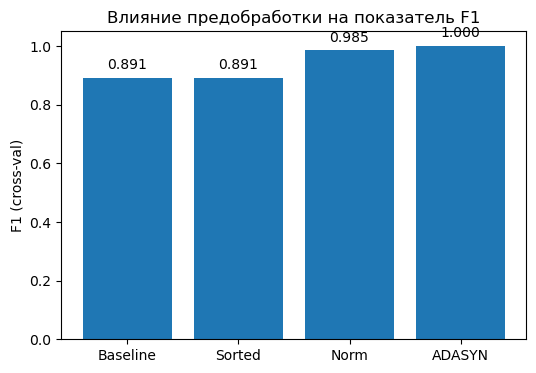

In [20]:
import matplotlib.pyplot as plt

# 把下面四个数字替换成自己实验中记录的交叉验证 F1
f1_baseline = 0.891     # Baseline（原始数据）
f1_sorted   = 0.891     # Sorted   （排序数据）
f1_norm     = 0.985     # Norm     （归一化数据）
f1_adasyn   = 1.000     # ADASYN   （归一化 + 平衡，最佳）

labels = ['Baseline', 'Sorted', 'Norm', 'ADASYN']
scores = [f1_baseline, f1_sorted, f1_norm, f1_adasyn]

plt.figure(figsize=(6,4))
bars = plt.bar(labels, scores)
plt.ylim(0, 1.05)
plt.ylabel('F1 (cross-val)')
plt.title('Влияние предобработки на показатель F1')

# 在柱顶显示数值
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2,
             score + 0.02,
             f'{score:.3f}',
             ha='center', va='bottom', fontsize=10)

plt.show()
